In [63]:
from tqdm import trange
import random

import os
import time
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.optim.adam import Adam
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [64]:
data = pd.read_csv('../Data/train.csv')
print(data.dtypes)

Date      object
Open       int64
High       int64
Low        int64
Volume     int64
Close      int64
dtype: object


In [65]:
df = data.loc[:, ['Date', 'Open']]
df.rename(columns = {'Open':'AC'}, inplace = True)
df['DAC'] = df['AC'] - df['AC'].shift(1)
df['DDAC'] = df['DAC'] - df['DAC'].shift(1)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace = True)

,Date,Open,High,Low,Volume,Close
0,2015-12-16,120,123,118,13181000,123
1,2015-12-17,124,126,122,17284900,123
2,2015-12-18,121,122,118,17948100,118
3,2015-12-21,120,120,116,11670000,117
4,2015-12-22,117,117,115,9689000,116


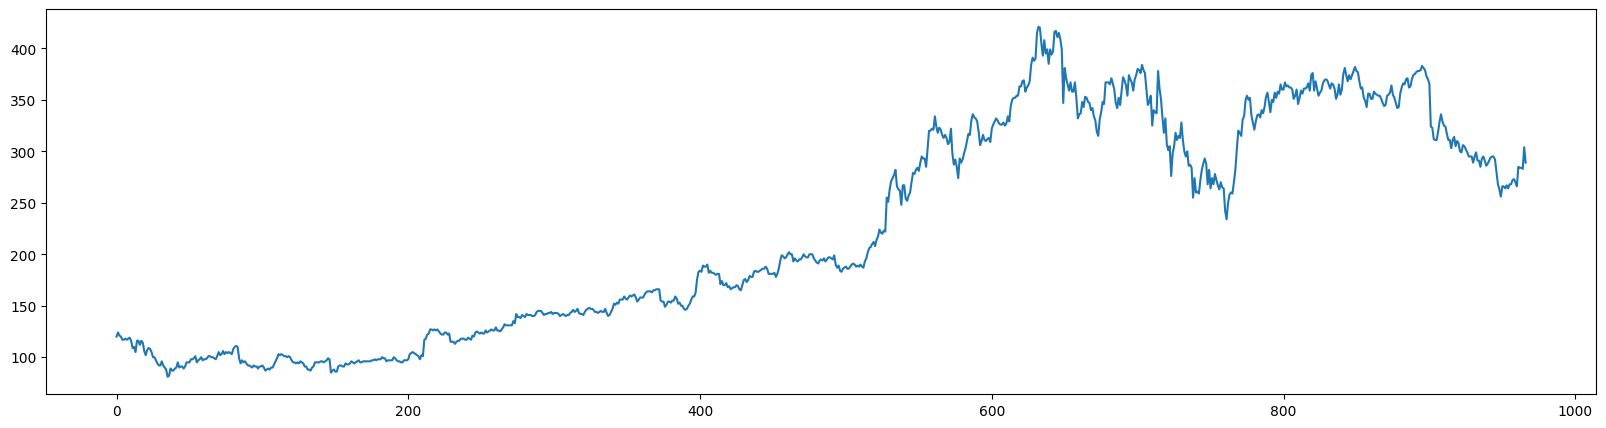

In [66]:
plt.figure(figsize=(20,5))
plt.plot(range(len(data)), df["AC"])
data.head()

,Unnamed: 0,집계일시,평균속도
0,0,2021050100,98.63
1,1,2021050101,100.53
2,2,2021050102,99.86
3,3,2021050103,99.34
4,4,2021050104,93.64


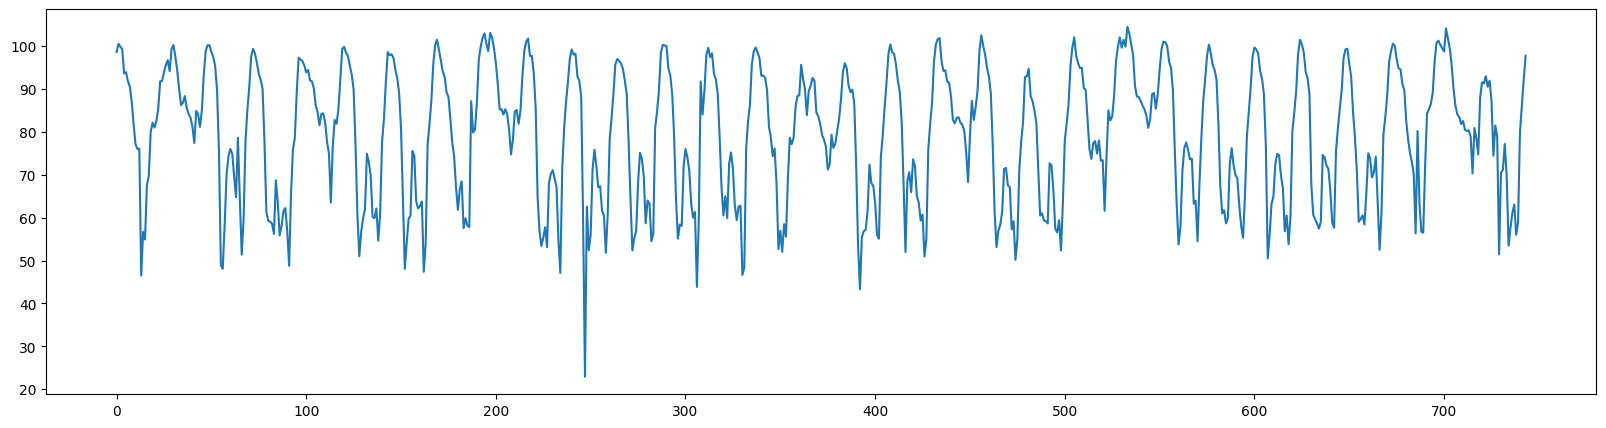

In [72]:
data = pd.read_csv("../Data/서인천IC-부평IC 평균속도.csv", encoding='CP949')
plt.figure(figsize=(20,5))
plt.plot(range(len(data)), data["평균속도"])
data.head()

In [68]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
data["평균속도"] = min_max_scaler.fit_transform(data["평균속도"].to_numpy().reshape(-1,1))

In [134]:
train = data[:500]
train = train["평균속도"].to_numpy()

test = data[500:]
test = test["평균속도"].to_numpy()

print(train.shape)
print(test.shape)

(500,)
(244,)


In [135]:
from torch.utils.data import DataLoader, Dataset

class windowDataset(Dataset):
    def __init__(self, y, input_window, output_window, stride=1):
        #총 데이터의 개수
        L = y.shape[0]
        #stride씩 움직일 때 생기는 총 sample의 개수
        num_samples = (L - input_window - output_window) // stride + 1

        #input과 output : shape = (window 크기, sample 개수)
        X = np.zeros([input_window, num_samples])
        Y = np.zeros([output_window, num_samples])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i] = y[start_x:end_x]

            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[:,i] = y[start_y:end_y]

        X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
        Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))
        self.x = X
        self.y = Y
        
        self.len = len(X)
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    def __len__(self):
        return self.len

In [136]:
print(train.shape)
print(test.shape)

(500,)
(244,)


In [220]:
input_window = 60
output_window = 7
stride = 1

L = train.shape[0]
#stride씩 움직일 때 생기는 총 sample의 개수
num_samples = (L - input_window - output_window) // stride + 1

#input과 output : shape = (window 크기, sample 개수)
X = np.zeros([input_window, num_samples])
Y = np.zeros([output_window, num_samples])

for i in np.arange(num_samples):
    start_x = stride*i
    end_x = start_x + input_window
    X[:,i] = train[start_x:end_x]

    start_y = stride*i + input_window
    end_y = start_y + output_window
    Y[:,i] = train[start_y:end_y]

X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))


In [222]:
print(X.shape)
print(Y.shape)

(434, 60, 1)
(434, 7, 1)


In [142]:
iw = 60
ow = 7

train_dataset = windowDataset(train, input_window=iw, output_window=ow, stride=1)
train_loader = DataLoader(train_dataset, batch_size=64)

In [262]:
class lstm_encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first=True)

    def forward(self, x_input):
        print('')
        print('')
        print('')
        print('')
        print('Encoder')
        print("input_size: ", x_input.shape)        
        lstm_out, self.hidden = self.lstm(x_input)
        print("lstm_out_size: ", lstm_out.shape)
        print("hidden_size: ", self.hidden[0].shape)
        #print(lstm_out)
        return lstm_out, self.hidden

In [243]:
class lstm_decoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,num_layers = num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, input_size)           

    def forward(self, x_input, encoder_hidden_states):
        print('Decoder')
        print("x_input_size: ", x_input.shape)
        print(x_input)
        lstm_out, self.hidden = self.lstm(x_input.unsqueeze(-1), encoder_hidden_states)
        print("lstm_out_size: ", lstm_out.shape)
        print("hidden_size: ", self.hidden[0].shape)
        output = self.linear(lstm_out)
        print("output_size: ", output.shape)
        
        return output, self.hidden

In [247]:
class lstm_encoder_decoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(lstm_encoder_decoder, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = lstm_encoder(input_size = input_size, hidden_size = hidden_size)
        self.decoder = lstm_decoder(input_size = input_size, hidden_size = hidden_size)

    def forward(self, inputs, targets, target_len, teacher_forcing_ratio):
        batch_size = inputs.shape[0]
        input_size = inputs.shape[2]

        outputs = torch.zeros(batch_size, target_len, input_size)

        _, hidden = self.encoder(inputs)
        decoder_input = inputs[:,-1, :]
        
        #원하는 길이가 될 때까지 decoder를 실행한다.
        for t in range(target_len): 
            out, hidden = self.decoder(decoder_input, hidden)
            out =  out.squeeze(1)
            
            # teacher forcing을 구현한다.
            # teacher forcing에 해당하면 다음 인풋값으로는 예측한 값이 아니라 실제 값을 사용한다.
            if random.random() < teacher_forcing_ratio:
                decoder_input = targets[:, t, :]
            else:
                decoder_input = out
            outputs[:,t,:] = out

        return outputs

In [275]:
class lstm_decoder(nn.Module):
    def __init__(self, output_size, hidden_size, num_layers = 1):
        super(lstm_decoder, self).__init__()
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size = output_size,
                            hidden_size = hidden_size,
                            num_layers = num_layers,
                            batch_first = True)
        self.linear = nn.Linear(hidden_size, 1)
        
    def forward(self, x_input, encoder_hidden_states):
        print('Decoder')
        print("x_input_size: ", x_input.shape)
        lstm_out, self.hidden = self.lstm(x_input.unsqueeze(-1), encoder_hidden_states)
        print("lstm_out_size: ", lstm_out.shape)
        print("hidden_size: ", self.hidden[0].shape)
        output = self.linear(lstm_out)
        print("output_size: ", output.shape)
        
        return output, self.hidden

In [276]:
model = lstm_encoder_decoder(input_size=1, output_size = 1, hidden_size=16).to(device)

In [277]:
learning_rate=0.01
epoch = 1
optimizer = Adam(model.parameters(), lr = learning_rate)
criterion = nn.MSELoss()

In [278]:
class lstm_encoder_decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(lstm_encoder_decoder, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.encoder = lstm_encoder(input_size = input_size, hidden_size = hidden_size)
        self.decoder = lstm_decoder(output_size = output_size, hidden_size = hidden_size)

    def forward(self, inputs, targets, target_len, teacher_forcing_ratio):
        batch_size = inputs.shape[0]
        input_size = inputs.shape[2]
        print("inputs_size: ", inputs.shape)
        outputs = torch.zeros(batch_size, target_len, 1)
        print("outputs_size: ", outputs.shape)

        _, hidden = self.encoder(inputs)
        print("_ size: ", _.shape)
        print("hidden_size: ", hidden[0].shape)
        decoder_input = inputs[:,-1, :]
        print("decoder_input_size: ", decoder_input.shape)
        #원하는 길이가 될 때까지 decoder를 실행한다.
        for t in range(target_len): 
            out, hidden = self.decoder(decoder_input, hidden)
            out =  out.squeeze(1)
            
            # teacher forcing을 구현한다.
            # teacher forcing에 해당하면 다음 인풋값으로는 예측한 값이 아니라 실제 값을 사용한다.
            if random.random() < teacher_forcing_ratio:
                decoder_input = targets[:, t, :]
            else:
                decoder_input = out
            print("out_size: ", out.shape)
            outputs[:,t,:] = out

        return outputs


In [279]:
from tqdm import tqdm

model.train()
with tqdm(range(epoch)) as tr:
    for i in tr:
        total_loss = 0.0
        for x,y in train_loader:
            optimizer.zero_grad()
            x = x.to(device).float()
            y = y.to(device).float()
            output = model(x, y, ow, 0.6).to(device)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.cpu().item()
        tr.set_postfix(loss="{0:.5f}".format(total_loss/len(train_loader)))

100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.51it/s, loss=6221.25767]

inputs_size:  torch.Size([64, 60, 1])
outputs_size:  torch.Size([64, 7, 1])




Encoder
input_size:  torch.Size([64, 60, 1])
lstm_out_size:  torch.Size([64, 60, 16])
hidden_size:  torch.Size([1, 64, 16])
_ size:  torch.Size([64, 60, 16])
hidden_size:  torch.Size([1, 64, 16])
decoder_input_size:  torch.Size([64, 1])
Decoder
x_input_size:  torch.Size([64, 1])
lstm_out_size:  torch.Size([64, 1, 16])
hidden_size:  torch.Size([1, 64, 16])
output_size:  torch.Size([64, 1, 1])
out_size:  torch.Size([64, 1])
Decoder
x_input_size:  torch.Size([64, 1])
lstm_out_size:  torch.Size([64, 1, 16])
hidden_size:  torch.Size([1, 64, 16])
output_size:  torch.Size([64, 1, 1])
out_size:  torch.Size([64, 1])
Decoder
x_input_size:  torch.Size([64, 1])
lstm_out_size:  torch.Size([64, 1, 16])
hidden_size:  torch.Size([1, 64, 16])
output_size:  torch.Size([64, 1, 1])
out_size:  torch.Size([64, 1])
Decoder
x_input_size:  torch.Size([64, 1])
lstm_out_size:  torch.Size([64, 1, 16])
hidden_size:  torch.Size([1, 64, 

In [225]:
X[60]

array([[76.01],
       [74.91],
       [69.59],
       [64.77],
       [78.63],
       [64.41],
       [51.38],
       [59.73],
       [77.89],
       [85.24],
       [90.58],
       [97.63],
       [99.36],
       [98.24],
       [96.13],
       [93.54],
       [92.1 ],
       [90.03],
       [77.64],
       [61.32],
       [59.25],
       [59.08],
       [58.55],
       [56.2 ],
       [68.7 ],
       [63.62],
       [55.86],
       [57.99],
       [61.51],
       [62.23],
       [56.89],
       [48.77],
       [65.57],
       [75.84],
       [78.58],
       [89.09],
       [97.29],
       [96.91],
       [96.52],
       [95.49],
       [93.89],
       [94.44],
       [92.  ],
       [91.81],
       [90.23],
       [86.25],
       [84.58],
       [81.55],
       [84.2 ],
       [84.33],
       [82.21],
       [77.65],
       [74.94],
       [63.52],
       [76.63],
       [82.82],
       [81.88],
       [85.35],
       [92.32],
       [99.38]])

In [226]:
x[:, -1, :]

tensor([[ 83.3100],
        [ 83.4100],
        [ 82.1500],
        [ 81.6300],
        [ 80.2000],
        [ 75.2000],
        [ 68.2800],
        [ 79.2700],
        [ 87.2300],
        [ 82.8100],
        [ 85.7400],
        [ 89.6400],
        [ 99.0000],
        [102.5400],
        [100.0000],
        [ 98.0400],
        [ 94.8700],
        [ 92.9000],
        [ 88.9800],
        [ 77.0000],
        [ 61.2000],
        [ 53.1400],
        [ 56.9600],
        [ 58.3700],
        [ 61.4200],
        [ 71.3800],
        [ 71.6000],
        [ 67.4800],
        [ 67.1400],
        [ 57.2700],
        [ 59.1800],
        [ 50.1700],
        [ 55.1400],
        [ 70.9700],
        [ 77.7100],
        [ 82.3700],
        [ 92.8300],
        [ 92.9500],
        [ 94.7100],
        [ 88.3300],
        [ 87.1800],
        [ 84.9600],
        [ 82.1300],
        [ 71.1000],
        [ 60.4900],
        [ 61.0300],
        [ 59.3400],
        [ 59.1900],
        [ 58.6300],
        [ 72.6900]],

In [208]:
y[:,-1,:]

tensor([[ 79.2700],
        [ 87.2300],
        [ 82.8100],
        [ 85.7400],
        [ 89.6400],
        [ 99.0000],
        [102.5400],
        [100.0000],
        [ 98.0400],
        [ 94.8700],
        [ 92.9000],
        [ 88.9800],
        [ 77.0000],
        [ 61.2000],
        [ 53.1400],
        [ 56.9600],
        [ 58.3700],
        [ 61.4200],
        [ 71.3800],
        [ 71.6000],
        [ 67.4800],
        [ 67.1400],
        [ 57.2700],
        [ 59.1800],
        [ 50.1700],
        [ 55.1400],
        [ 70.9700],
        [ 77.7100],
        [ 82.3700],
        [ 92.8300],
        [ 92.9500],
        [ 94.7100],
        [ 88.3300],
        [ 87.1800],
        [ 84.9600],
        [ 82.1300],
        [ 71.1000],
        [ 60.4900],
        [ 61.0300],
        [ 59.3400],
        [ 59.1900],
        [ 58.6300],
        [ 72.6900],
        [ 72.1800],
        [ 66.1700],
        [ 57.3100],
        [ 56.5700],
        [ 59.4000],
        [ 52.3400],
        [ 63.6600]],

In [26]:
predict = model.predict(torch.tensor(train[-24*7*2:]).reshape(-1,1).to(device).float(), target_len=ow)
real = data["평균속도"].to_numpy()

predict = min_max_scaler.inverse_transform(predict.reshape(-1,1))
real = min_max_scaler.inverse_transform(real.reshape(-1,1))

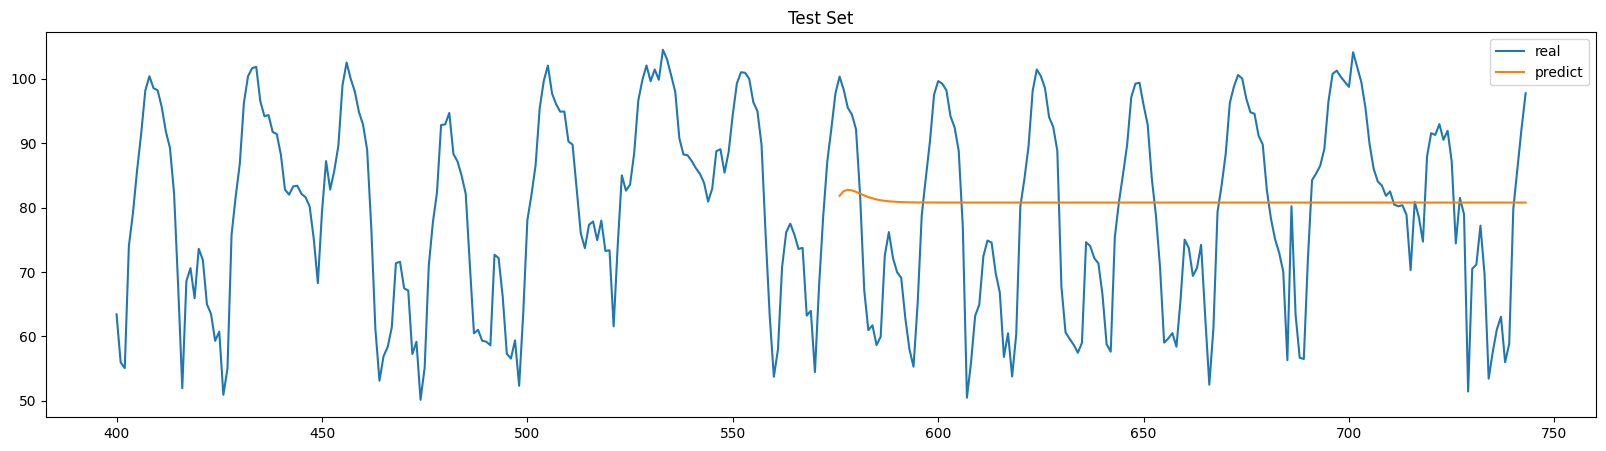

In [27]:
plt.figure(figsize=(20,5))
plt.plot(range(400,744), real[400:], label="real")
plt.plot(range(744-24*7,744), predict[-24*7:], label="predict")

plt.title("Test Set")
plt.legend()
plt.show()

In [28]:
def MAPEval(y_pred, y_true):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
MAPEval(predict[-24*7:],real[-24*7:])

17.727985331719616

In [269]:
a = torch.zeros([64, 3, 1])

In [272]:
a.shape

torch.Size([64, 3, 1])

In [273]:
a

tensor([[[0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.]],

        [[0.]

In [274]:
a.squeeze(1).shape

torch.Size([64, 3, 1])